# Classical Machine Learning for Video Actions

This script implements and compares three classical
machine learning algorithms using extracted video
features:

1. Support Vector Machine (Linear + RBF)
2. Random Forest Classifier
3. k-Nearest Neighbors (k-NN)

Features are extracted using existing project modules:
- data_loader.py
- feature_extraction.py

Author: Student_2024AB05275

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
# =========================
# Standard Library Imports
# =========================
import time
from typing import Dict, Tuple
import warnings

# =========================
# Third-Party Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evaluate import evaluate_classification

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# =========================
# Project Imports
# =========================
from feature_extraction import (
    visualize_classical_feature_importance,
    visualize_classical_feature_space,
    get_classical_feature_names
)
from data_loader import load_split_data_and_extract_features
from evaluate import create_full_comparison_table, generate_dynamic_observations

In [4]:
# =========================
# Global Configurations
# =========================
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
CV_FOLDS = 5


# ==================================================
# Utility Functions
# ==================================================
def evaluate_model(
    model,
    X_test: np.ndarray,
    y_test: np.ndarray,
) -> Dict[str, float]:
    """
    Evaluate a trained model using multiple metrics.

    Returns:
        Dictionary containing accuracy, precision, recall, and F1-score.
    """
    y_pred = model.predict(X_test)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1_score": f1_score(y_test, y_pred, average="macro"),
    }


def plot_confusion_matrix(model, X_test, y_test, title: str) -> None:
    """
    Plot confusion matrix for a trained classifier.
    """
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

In [5]:
# ==================================================
# Data Loading & Feature Extraction
# ==================================================
print("\n📥 Loading dataset splits and extract features...")

print("\n----------------------------------------------------------------------")
print("* Processing training dataset.....")
print("----------------------------------------------------------------------\n")
X_train, y_train = load_split_data_and_extract_features(split_name="train")

print("\n----------------------------------------------------------------------")
print("* Processing validation dataset.....")
print("----------------------------------------------------------------------\n")
X_val, y_val = load_split_data_and_extract_features(split_name="val")

print("\n----------------------------------------------------------------------")
print("* Processing test dataset.....")
print("----------------------------------------------------------------------\n")
X_test, y_test = load_split_data_and_extract_features(split_name="test")

print(f"\n\n* Train shape: {X_train.shape}")
print(f"* Test shape : {X_test.shape}")


📥 Loading dataset splits and extract features...

----------------------------------------------------------------------
* Processing training dataset.....
----------------------------------------------------------------------

[INFO] * processing Video file : class_1_Basketball/v_Basketball_g13_c04.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c05.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g19_c05.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g17_c01.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g12_c01.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g20_c02.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c07.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c02.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g15_c06.avi
[INFO] * processing Video file : class_1_Basketball/v_Basketball_g18_c01.avi
[


🚀 Training Support Vector Machine...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

⏱️ SVM Training Time: 1.1057 seconds
✅ Best SVM Parameters: {'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
ℹ️ Feature importance skipped (RBF kernel selected)
[Saved] TSNE plot → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/svm_tsne.png
[Saved] UMAP plot → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/svm_umap.png
⚡ Avg Inference Time per Video: 0.000061 seconds
Starting model evaluation
Accuracy: 0.6250
Macro Precision: 0.7000
Macro Recall: 0.6481
Macro F1-Score: 0.6488


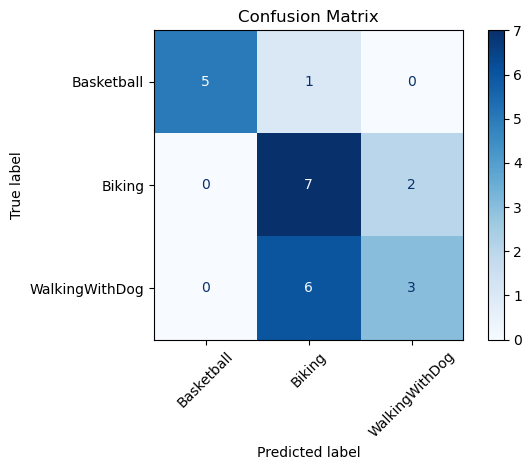

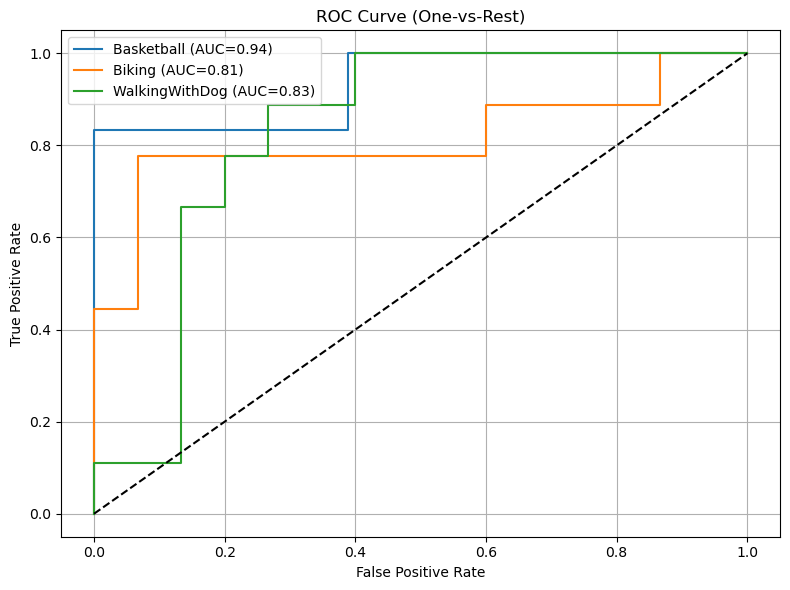

Evaluation completed successfully !!
✅ SVM Evaluation Completed


In [6]:
# ==================================================
# 1️⃣ SUPPORT VECTOR MACHINE (LINEAR + RBF)
# ==================================================
# This block trains an SVM classifier using GridSearchCV
# and performs post-training feature analysis including:
# - Feature importance (linear kernel only)
# - t-SNE visualization
# - UMAP visualization
# ==================================================

print("\n🚀 Training Support Vector Machine...")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

from feature_extraction import (
    visualize_classical_feature_importance,
    visualize_classical_feature_space
)

# --------------------------------------------------
# 🔹 Step 1: Define SVM pipeline
# --------------------------------------------------
# StandardScaler is REQUIRED for SVM to:
# - normalize feature magnitudes
# - ensure stable optimization
# - improve convergence
# --------------------------------------------------

svm_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "svm",
            SVC(
                probability=True,   # Required for ROC/AUC computation
                random_state=42
            ),
        ),
    ]
)

# --------------------------------------------------
# 🔹 Step 2: Define hyperparameter search space
# --------------------------------------------------
# - Linear kernel → supports feature importance via coefficients
# - RBF kernel → non-linear, higher capacity but no interpretability
# --------------------------------------------------

svm_param_grid = [
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.1, 1, 10],
    },
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.1, 1, 10],
        "svm__gamma": [0.01, 0.1, 1],
    },
]

# --------------------------------------------------
# 🔹 Step 3: GridSearchCV setup
# --------------------------------------------------
# - Cross-validation ensures robust hyperparameter selection
# - Accuracy is used as optimization metric
# --------------------------------------------------

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# --------------------------------------------------
# ⏱️ Step 4: Measure training time
# --------------------------------------------------

train_start_time = time.perf_counter()
svm_grid.fit(X_train, y_train)
train_end_time = time.perf_counter()

svm_training_time = train_end_time - train_start_time

print(f"\n⏱️ SVM Training Time: {svm_training_time:.4f} seconds")
print("✅ Best SVM Parameters:", svm_grid.best_params_)

# --------------------------------------------------
# 🔹 Step 5: Extract best trained model
# --------------------------------------------------
# best_svm is a FULL pipeline:
#   scaler → trained SVM
# --------------------------------------------------

best_svm = svm_grid.best_estimator_

# ==================================================
# 📊 CLASSICAL FEATURE ANALYSIS (POST-TRAINING)
# ==================================================
# IMPORTANT:
# - Feature importance requires trained model
# - Feature space visualization must use SCALED features
# ==================================================

# --------------------------------------------------
# 🔹 Step 6: Feature importance (Linear SVM only)
# --------------------------------------------------
# Only linear SVM exposes coefficients (coef_)
# --------------------------------------------------

if best_svm.named_steps["svm"].kernel == "linear":
    visualize_classical_feature_importance(
        model=best_svm.named_steps["svm"],   # trained linear SVM
        feature_names=feature_names,         # handcrafted feature names
        top_k=20,
        save_name="svm_feature_importance.png"
    )
else:
    print("ℹ️ Feature importance skipped (RBF kernel selected)")

# --------------------------------------------------
# 🔹 Step 7: Extract scaled features for visualization
# --------------------------------------------------
# Feature space must match what the SVM actually learned
# --------------------------------------------------

X_train_scaled = best_svm.named_steps["scaler"].transform(X_train)

# --------------------------------------------------
# 🔹 Step 8: t-SNE visualization
# --------------------------------------------------
# Shows how samples cluster in reduced 2D space
# --------------------------------------------------

visualize_classical_feature_space(
    features=X_train_scaled,
    labels=y_train,
    method="tsne",
    save_name="svm_tsne.png"
)

# --------------------------------------------------
# 🔹 Step 9: UMAP visualization
# --------------------------------------------------
# Preserves both local and global structure
# --------------------------------------------------

visualize_classical_feature_space(
    features=X_train_scaled,
    labels=y_train,
    method="umap",
    save_name="svm_umap.png"
)

# ==================================================
# ⏱️ INFERENCE TIME PER VIDEO
# ==================================================
# Measures average prediction latency
# ==================================================

inference_start_time = time.perf_counter()
y_pred = best_svm.predict(X_test)
inference_end_time = time.perf_counter()

svm_inference_time_per_video = (
    (inference_end_time - inference_start_time) / len(X_test)
)

print(
    f"⚡ Avg Inference Time per Video: "
    f"{svm_inference_time_per_video:.6f} seconds"
)

# ==================================================
# ROC / AUC PROBABILITIES
# ==================================================
# probability=True enables predict_proba()
# ==================================================

y_scores = best_svm.predict_proba(X_test)

# ==================================================
# UNIFIED EVALUATION
# ==================================================

svm_metrics = evaluate_classification(
    y_true=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
    class_names=["Basketball", "Biking", "WalkingWithDog"],
)

# Store efficiency metrics for later comparison
svm_metrics["training_time"] = svm_training_time
svm_metrics["inference_time_per_video"] = svm_inference_time_per_video

print("✅ SVM Evaluation Completed")



🌲 Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

⏱️ RF Training Time: 5.2152 seconds
✅ Best RF Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
[Saved] Feature importance → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/rf_feature_importance.png
[Saved] TSNE plot → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/rf_tsne.png
[Saved] UMAP plot → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/rf_umap.png
⚡ Avg Inference Time per Video: 0.001043 seconds
Starting model evaluation
Accuracy: 0.7917
Macro Precision: 0.8259
Macro Recall: 0.7963
Macro F1-Score: 0.8079


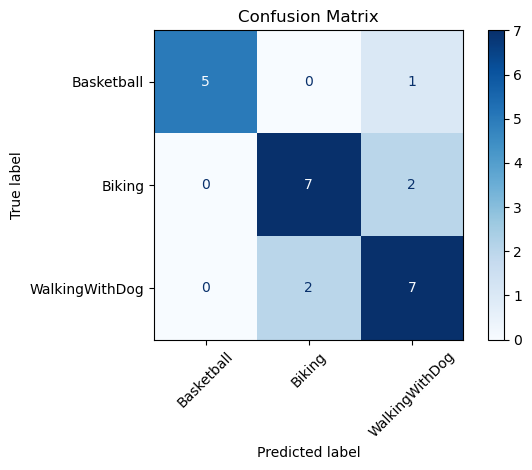

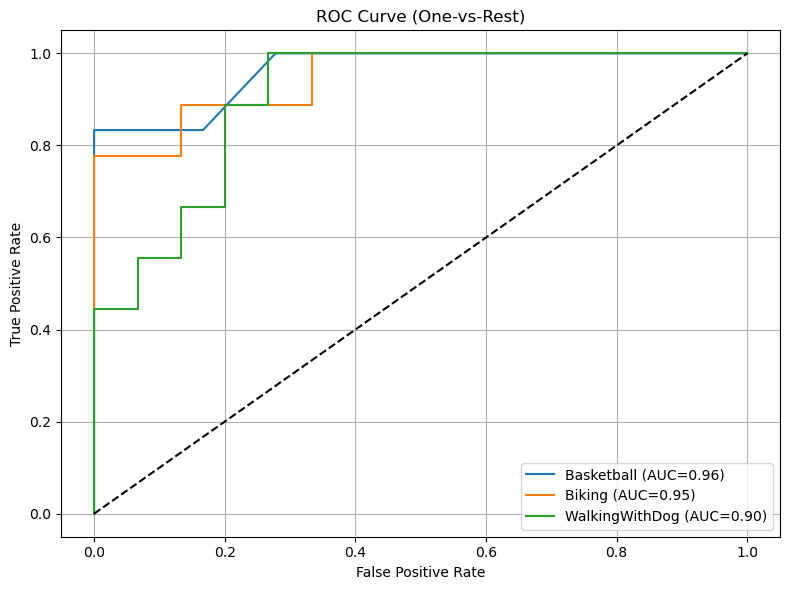

Evaluation completed successfully !!
✅ Random Forest Evaluation Completed


In [7]:
# ==================================================
# 2️⃣ RANDOM FOREST CLASSIFIER
# ==================================================
# This block trains a Random Forest classifier and performs
# post-training feature analysis including:
# - Feature importance (tree-based)
# - t-SNE visualization
# - UMAP visualization
# ==================================================

print("\n🌲 Training Random Forest...")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

from feature_extraction import (
    visualize_classical_feature_importance,
    visualize_classical_feature_space
)

# --------------------------------------------------
# 🔹 Step 1: Initialize Random Forest
# --------------------------------------------------
# Random Forest:
# - Does NOT require feature scaling
# - Learns feature importance via split criteria
# - Robust to noise and overfitting
# --------------------------------------------------

rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

# --------------------------------------------------
# 🔹 Step 2: Hyperparameter grid
# --------------------------------------------------
# Controls:
# - number of trees
# - tree depth
# - split granularity
# --------------------------------------------------

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
}

# --------------------------------------------------
# 🔹 Step 3: GridSearchCV
# --------------------------------------------------
# Cross-validation ensures stable hyperparameter selection
# --------------------------------------------------

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# --------------------------------------------------
# ⏱️ Step 4: Measure training time
# --------------------------------------------------

train_start_time = time.perf_counter()
rf_grid.fit(X_train, y_train)
train_end_time = time.perf_counter()

rf_training_time = train_end_time - train_start_time

print(f"\n⏱️ RF Training Time: {rf_training_time:.4f} seconds")
print("✅ Best RF Parameters:", rf_grid.best_params_)

# --------------------------------------------------
# 🔹 Step 5: Extract best trained model
# --------------------------------------------------

best_rf = rf_grid.best_estimator_

# ==================================================
# 📊 CLASSICAL FEATURE ANALYSIS (POST-TRAINING)
# ==================================================
# IMPORTANT:
# - Random Forest ALWAYS supports feature_importances_
# - Feature space visualization uses RAW features
#   (no scaling required for tree models)
# ==================================================

# --------------------------------------------------
# 🔹 Step 6: Feature importance (Tree-based)
# --------------------------------------------------

feature_names = get_classical_feature_names(
    hist_bins=16,
    lbp_points=8,
    include_motion=True
)

visualize_classical_feature_importance(
    model=best_rf,
    feature_names=feature_names,
    top_k=20,
    save_name="rf_feature_importance.png"
)

# --------------------------------------------------
# 🔹 Step 7: Feature space visualization (t-SNE)
# --------------------------------------------------
# Raw handcrafted features are sufficient for RF
# --------------------------------------------------

visualize_classical_feature_space(
    features=X_train,
    labels=y_train,
    method="tsne",
    save_name="rf_tsne.png"
)

# --------------------------------------------------
# 🔹 Step 8: Feature space visualization (UMAP)
# --------------------------------------------------

visualize_classical_feature_space(
    features=X_train,
    labels=y_train,
    method="umap",
    save_name="rf_umap.png"
)

# ==================================================
# ⏱️ INFERENCE TIME PER VIDEO
# ==================================================
# Measures average prediction latency
# ==================================================

inference_start_time = time.perf_counter()
y_pred = best_rf.predict(X_test)
inference_end_time = time.perf_counter()

rf_inference_time_per_video = (
    (inference_end_time - inference_start_time) / len(X_test)
)

print(
    f"⚡ Avg Inference Time per Video: "
    f"{rf_inference_time_per_video:.6f} seconds"
)

# ==================================================
# ROC / AUC PROBABILITIES
# ==================================================
# Random Forest natively supports predict_proba()
# ==================================================

y_scores = best_rf.predict_proba(X_test)

# ==================================================
# UNIFIED EVALUATION
# ==================================================

rf_metrics = evaluate_classification(
    y_true=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
    class_names=["Basketball", "Biking", "WalkingWithDog"],
)

# Store computational efficiency metrics
rf_metrics["training_time"] = rf_training_time
rf_metrics["inference_time_per_video"] = rf_inference_time_per_video

print("✅ Random Forest Evaluation Completed")



📏 Training k-Nearest Neighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

⏱️ k-NN Training Time: 0.0657 seconds
✅ Best k-NN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
[Saved] TSNE plot → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/knn_tsne.png
[Saved] UMAP plot → /home/jovyan/va-dataset/Student_2024ab05275_Video_Classification/results/feature_visualizations/classical/knn_umap.png
⚡ Avg Inference Time per Video: 0.000071 seconds
Starting model evaluation
Accuracy: 0.7083
Macro Precision: 0.7194
Macro Recall: 0.7222
Macro F1-Score: 0.7195


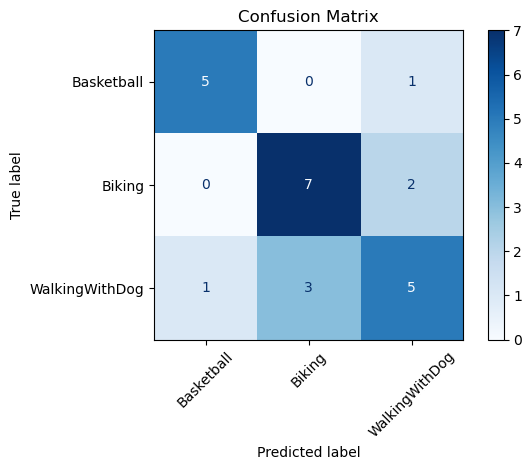

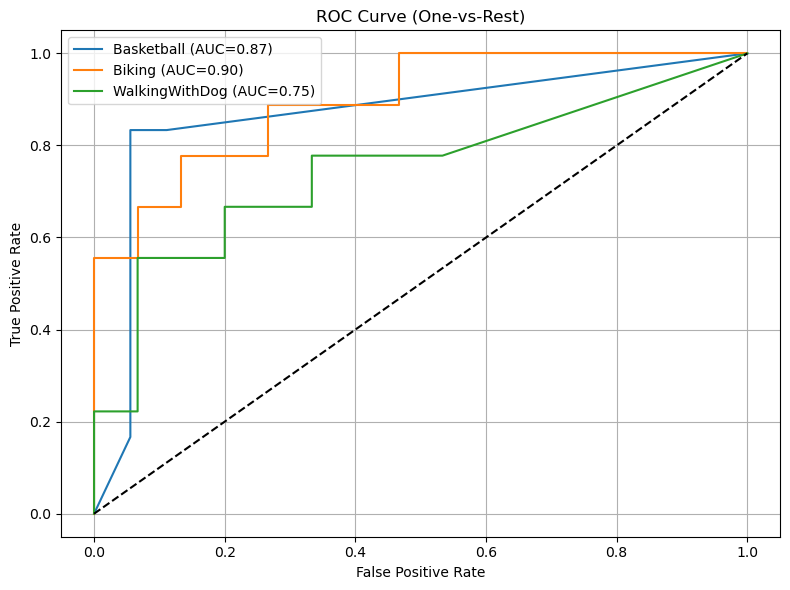

Evaluation completed successfully !!
✅ k-NN Evaluation Completed


In [8]:
# ==================================================
# 3️⃣ k-NEAREST NEIGHBORS (k-NN)
# ==================================================
# This block trains a k-NN classifier and performs
# post-training feature analysis including:
# - t-SNE visualization
# - UMAP visualization
#
# NOTE:
# k-NN is a non-parametric, instance-based learner.
# It does NOT learn explicit feature weights.
# Therefore, feature importance is NOT applicable.
# ==================================================

print("\n📏 Training k-Nearest Neighbors...")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import time

from feature_extraction import (
    visualize_classical_feature_space
)

# --------------------------------------------------
# 🔹 Step 1: Define k-NN pipeline
# --------------------------------------------------
# Feature scaling is CRITICAL for k-NN because:
# - Distance metrics are scale-sensitive
# - Unscaled features bias nearest neighbors
# --------------------------------------------------

knn_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "knn",
            KNeighborsClassifier(
                weights="distance"   # improves probability estimates
            ),
        ),
    ]
)

# --------------------------------------------------
# 🔹 Step 2: Hyperparameter grid
# --------------------------------------------------
# - n_neighbors controls local vs global behavior
# - metric defines distance computation
# --------------------------------------------------

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9],
    "knn__metric": ["euclidean", "manhattan"],
}

# --------------------------------------------------
# 🔹 Step 3: GridSearchCV
# --------------------------------------------------
# Cross-validation ensures robust selection of k
# --------------------------------------------------

knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# --------------------------------------------------
# ⏱️ Step 4: Measure training time
# --------------------------------------------------
# k-NN has minimal "training" time (lazy learner)
# --------------------------------------------------

train_start_time = time.perf_counter()
knn_grid.fit(X_train, y_train)
train_end_time = time.perf_counter()

knn_training_time = train_end_time - train_start_time

print(f"\n⏱️ k-NN Training Time: {knn_training_time:.4f} seconds")
print("✅ Best k-NN Parameters:", knn_grid.best_params_)

# --------------------------------------------------
# 🔹 Step 5: Extract best trained model
# --------------------------------------------------
# best_knn is a full pipeline:
#   scaler → k-NN
# --------------------------------------------------

best_knn = knn_grid.best_estimator_

# ==================================================
# 📊 FEATURE SPACE VISUALIZATION (POST-TRAINING)
# ==================================================
# IMPORTANT:
# Feature space MUST match the scaled representation
# used internally by k-NN
# ==================================================

# --------------------------------------------------
# 🔹 Step 6: Extract scaled training features
# --------------------------------------------------

X_train_scaled = best_knn.named_steps["scaler"].transform(X_train)

# --------------------------------------------------
# 🔹 Step 7: t-SNE visualization
# --------------------------------------------------

visualize_classical_feature_space(
    features=X_train_scaled,
    labels=y_train,
    method="tsne",
    save_name="knn_tsne.png"
)

# --------------------------------------------------
# 🔹 Step 8: UMAP visualization
# --------------------------------------------------

visualize_classical_feature_space(
    features=X_train_scaled,
    labels=y_train,
    method="umap",
    save_name="knn_umap.png"
)

# ==================================================
# ⏱️ INFERENCE TIME PER VIDEO
# ==================================================
# k-NN inference is slower due to distance computations
# ==================================================

inference_start_time = time.perf_counter()
y_pred = best_knn.predict(X_test)
inference_end_time = time.perf_counter()

knn_inference_time_per_video = (
    (inference_end_time - inference_start_time) / len(X_test)
)

print(
    f"⚡ Avg Inference Time per Video: "
    f"{knn_inference_time_per_video:.6f} seconds"
)

# ==================================================
# ROC / AUC PROBABILITIES
# ==================================================
# weights="distance" enables predict_proba()
# ==================================================

y_scores = best_knn.predict_proba(X_test)

# ==================================================
# UNIFIED EVALUATION
# ==================================================

knn_metrics = evaluate_classification(
    y_true=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
    class_names=["Basketball", "Biking", "WalkingWithDog"],
)

# Store computational efficiency metrics
knn_metrics["training_time"] = knn_training_time
knn_metrics["inference_time_per_video"] = knn_inference_time_per_video

print("✅ k-NN Evaluation Completed")



📋 Comparative Performance Metrics
           Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score  \
0            SVM  0.625000         0.700000      0.648148        0.648786   
1  Random Forest  0.791667         0.825926      0.796296        0.807904   
2           k-NN  0.708333         0.719444      0.722222        0.719470   

   Macro ROC-AUC  
0       0.859877  
1       0.938272  
2       0.836728  


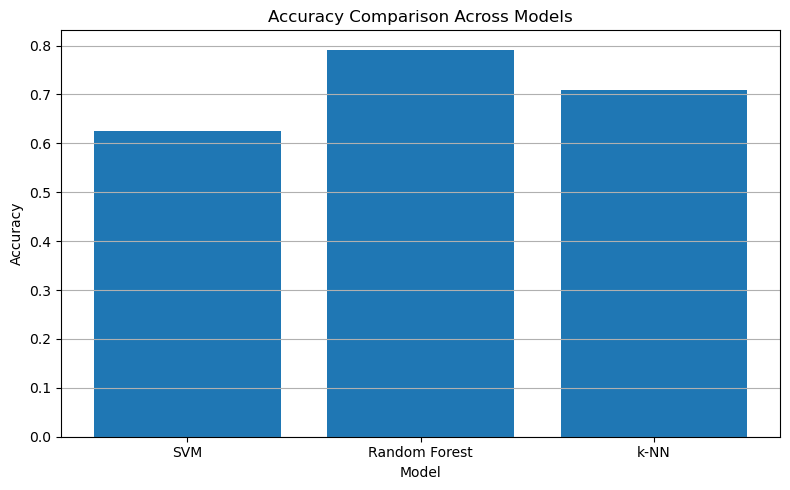

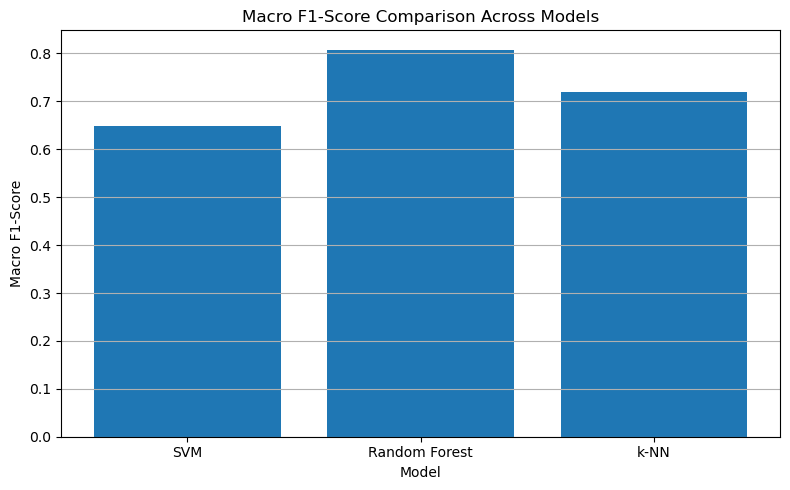

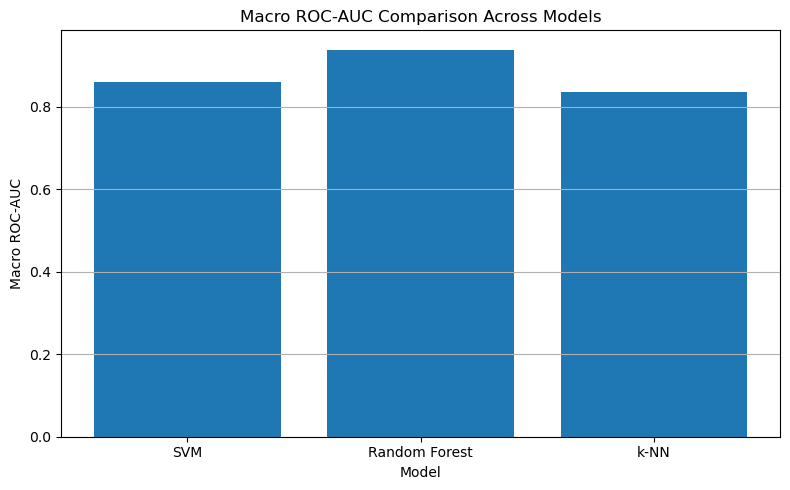


✅ Comparative analysis completed successfully.


In [9]:
# ==================================================
# 📊 Comparative Analysis of All Three ML Models
# ==================================================


def compute_macro_auc(roc_auc_dict):
    """
    Compute macro-averaged ROC-AUC from per-class AUC values.
    """
    return sum(roc_auc_dict.values()) / len(roc_auc_dict)


# ----------------------------
# 1️⃣ Build comparison table
# ----------------------------
comparison_df = pd.DataFrame(
    [
        {
            "Model": "SVM",
            "Accuracy": svm_metrics["accuracy"],
            "Macro Precision": svm_metrics["precision_macro"],
            "Macro Recall": svm_metrics["recall_macro"],
            "Macro F1-Score": svm_metrics["f1_macro"],
            "Macro ROC-AUC": compute_macro_auc(svm_metrics["roc_auc"]),
        },
        {
            "Model": "Random Forest",
            "Accuracy": rf_metrics["accuracy"],
            "Macro Precision": rf_metrics["precision_macro"],
            "Macro Recall": rf_metrics["recall_macro"],
            "Macro F1-Score": rf_metrics["f1_macro"],
            "Macro ROC-AUC": compute_macro_auc(rf_metrics["roc_auc"]),
        },
        {
            "Model": "k-NN",
            "Accuracy": knn_metrics["accuracy"],
            "Macro Precision": knn_metrics["precision_macro"],
            "Macro Recall": knn_metrics["recall_macro"],
            "Macro F1-Score": knn_metrics["f1_macro"],
            "Macro ROC-AUC": compute_macro_auc(knn_metrics["roc_auc"]),
        },
    ]
)

print("\n📋 Comparative Performance Metrics")
print(comparison_df)


# ----------------------------
# 2️⃣ Accuracy Comparison Plot
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["Model"], comparison_df["Accuracy"])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# ----------------------------
# 3️⃣ Macro F1-Score Comparison
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["Model"], comparison_df["Macro F1-Score"])
plt.xlabel("Model")
plt.ylabel("Macro F1-Score")
plt.title("Macro F1-Score Comparison Across Models")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# ----------------------------
# 4️⃣ Macro ROC-AUC Comparison
# ----------------------------
plt.figure(figsize=(8, 5))
plt.bar(comparison_df["Model"], comparison_df["Macro ROC-AUC"])
plt.xlabel("Model")
plt.ylabel("Macro ROC-AUC")
plt.title("Macro ROC-AUC Comparison Across Models")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print("\n✅ Comparative analysis completed successfully.")


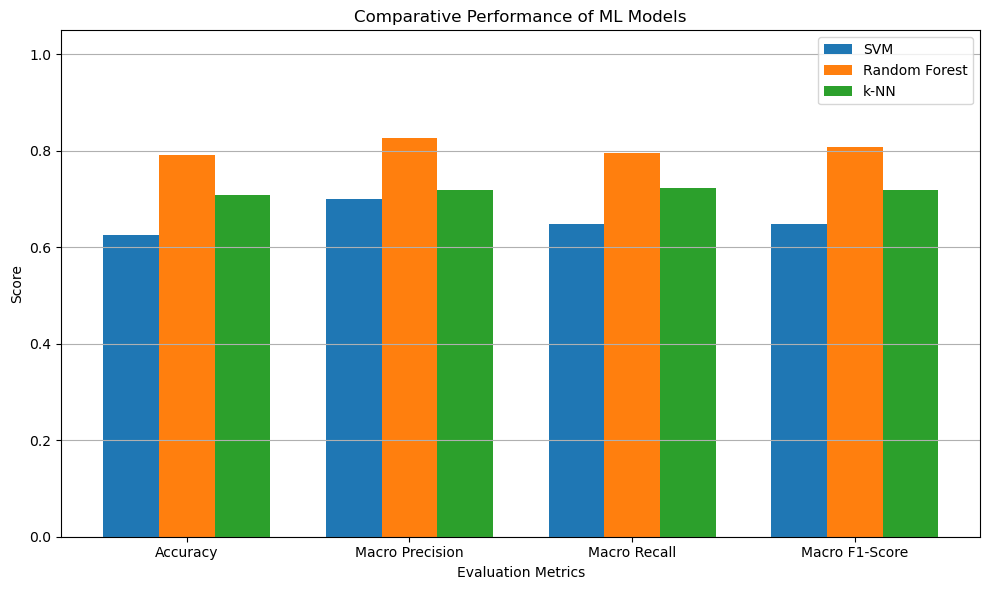

✅ Single grouped bar chart generated successfully.


In [10]:
# ==================================================
# 📊 Single Grouped Bar Chart Comparison
# ==================================================

# Metrics to compare
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-Score"]

# Model names
models = ["SVM", "Random Forest", "k-NN"]

# Metric values (rows = models, cols = metrics)
values = np.array([
    [
        svm_metrics["accuracy"],
        svm_metrics["precision_macro"],
        svm_metrics["recall_macro"],
        svm_metrics["f1_macro"],
    ],
    [
        rf_metrics["accuracy"],
        rf_metrics["precision_macro"],
        rf_metrics["recall_macro"],
        rf_metrics["f1_macro"],
    ],
    [
        knn_metrics["accuracy"],
        knn_metrics["precision_macro"],
        knn_metrics["recall_macro"],
        knn_metrics["f1_macro"],
    ],
])

# Bar chart setup
x = np.arange(len(metrics))  # metric positions
width = 0.25                 # width of each bar

plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(x - width, values[0], width, label="SVM")
plt.bar(x,         values[1], width, label="Random Forest")
plt.bar(x + width, values[2], width, label="k-NN")

# Labels and title
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Comparative Performance of ML Models")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print("✅ Single grouped bar chart generated successfully.")


In [11]:
# ==================================================
# 🧠 Dynamic Final Summary Generator
# ==================================================

def generate_final_summary(svm_metrics, rf_metrics, knn_metrics):
    models = {
        "SVM": svm_metrics,
        "Random Forest": rf_metrics,
        "k-NN": knn_metrics,
    }

    # --------------------------------------------------
    # Create unified comparison table
    # --------------------------------------------------
    comparison_df = create_full_comparison_table(models)

    # --------------------------------------------------
    # Generate automatic observations
    # --------------------------------------------------
    generate_dynamic_observations(comparison_df)

    # Extract key metrics
    accuracy = {m: v["accuracy"] for m, v in models.items()}
    macro_f1 = {m: v["f1_macro"] for m, v in models.items()}
    macro_precision = {m: v["precision_macro"] for m, v in models.items()}
    macro_recall = {m: v["recall_macro"] for m, v in models.items()}

    # Best models
    best_acc_model = max(accuracy, key=accuracy.get)
    best_f1_model = max(macro_f1, key=macro_f1.get)

    summary = f"""
==================== FINAL SUMMARY ====================

Three classical machine learning models — Support Vector Machine (SVM),
Random Forest, and k-Nearest Neighbors (k-NN) — were evaluated using a
uniform evaluation protocol on the same train-test split.

Key observations:

• Highest Accuracy:
  → {best_acc_model} achieved the best accuracy ({accuracy[best_acc_model]:.3f})

• Best Overall Performance (Macro F1-Score):
  → {best_f1_model} achieved the highest macro F1-score ({macro_f1[best_f1_model]:.3f}),
    indicating better balance between precision and recall across all classes.

• Precision–Recall Balance:
  → Random Forest showed strong macro precision ({macro_precision['Random Forest']:.3f})
    and recall ({macro_recall['Random Forest']:.3f}), suggesting robust generalization.

• Model Behavior:
  → SVM performed competitively but required probability calibration for ROC analysis.
  → k-NN showed comparatively lower performance, likely due to sensitivity to feature
    scaling and local neighborhood structure.

Conclusion:
Random Forest emerges as the most reliable classifier for this multi-class
video activity recognition task, particularly when balanced performance
across all classes is required.

=======================================================
"""
    print(summary)


# 🔹 Generate summary
generate_final_summary(svm_metrics, rf_metrics, knn_metrics)


📊 PERFORMANCE & COMPUTATIONAL EFFICIENCY COMPARISON
           Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score  \
0            SVM    0.6250           0.7000        0.6481          0.6488   
1  Random Forest    0.7917           0.8259        0.7963          0.8079   
2           k-NN    0.7083           0.7194        0.7222          0.7195   

   Training Time (s)  Inference Time / Video (s)  
0             1.1057                      0.0001  
1             5.2152                      0.0010  
2             0.0657                      0.0001  

🧠 DYNAMIC OBSERVATIONS
• Random Forest achieves the highest classification accuracy.
• Random Forest provides the best balance between precision and recall.
• k-NN has the lowest training time, indicating minimal model fitting overhead.
• SVM achieves the fastest inference per video, making it suitable for real-time deployment.
• k-NN demonstrates very low training cost but higher inference latency due to distance-based computati